# Imports

In [1]:
%autosave 180

Autosaving every 180 seconds


In [2]:
%matplotlib inline
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from astropy.utils.data import get_pkg_data_filename
import numpy as np
import galsim
import os
import math
import time
import loggingsss
import sys
import fitsio

# Read Chinchilla Catalog

In [3]:
file = os.path.join('/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/','Chinchilla-4_lensed.4.fits')

span = range(100000)

_HLR = fitsio.read(file, columns='SIZE', rows=span, ext=1)
LMAG = fitsio.read(file, columns = 'LMAG', rows=span, ext=1)
EPSILON = fitsio.read(file, columns='EPSILON', rows=span, ext=1)
RBAND = LMAG[:,1]
E1 = EPSILON[:,0]
E2 = EPSILON[:,1]

In [4]:
x, y = np.mgrid[-24.5:25.5:1, -24.5:25.5:1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

def matrixflux(integer): # params should be the number of galaxies (or maybe a catalog), and a noise object maybe, or we can just call the noise within the function
    matrixfluxes = np.zeros(integer)
    gfluxes = np.zeros(integer)
    images = []
    deltafluxes = np.zeros(integer)
    counter = 0
    for i in range(integer):
        
        rng = galsim.BaseDeviate(215324) # make noise object
        noise = galsim.GaussianNoise(rng, sigma=0.005)
        
        hlradius = _HLR[i] # catalogs
        sigma = 1/(np.sqrt(2*np.log(2))) * hlradius 
        elip1 = E1[i]
        elip2 = E2[i]
        magnitude = RBAND[i]
        gflux = 10**((magnitude-22.5)/(-2.5))
        gfluxes[i] = gflux
    
        image = galsim.ImageF(50, 50) # make noise free image
        gal = galsim.Gaussian(flux=gflux, half_light_radius=hlradius)
        gal = gal.shear(galsim.Shear(e1=elip1, e2=elip2))
        final = galsim.Convolve([gal])
        image = final.drawImage(image, scale=0.02)
        images.append(image)
        
        noiseimage = galsim.ImageF(50, 50) # generate the noise
        noiseimage.addNoise(noise)
        
        shear = galsim.Shear(e1=-1*elip1, e2=elip2) # The negative sign in e1 is due to the difference in how GalSim treats shearing matrices
        matrix = (shear.getMatrix())*(sigma**2)*25  
        
        
        rv = multivariate_normal([0, 0], matrix)
        r1 = np.sum(np.multiply(rv.pdf(pos), image.array + noiseimage.array))
        r2 = np.sum(np.multiply(rv.pdf(pos), rv.pdf(pos)))
        delta = np.sum(np.multiply(rv.pdf(pos), image.array + noiseimage.array))
        matrixfluxes[i] = r1/r2
        deltafluxes[i] = delta/r2
 
    return matrixfluxes, deltafluxes, gfluxes, images, counter

In [5]:
matrixfluxes, deltafluxes, galaxyfluxes, images, counter = matrixflux(100000)
# problematic galaxies have 0.03207835723861807, 0.029314217378540914

In [12]:
print(1/(np.sqrt(2*np.log(2)))*np.amax(_HLR) + 0.7)



3.483518687602152


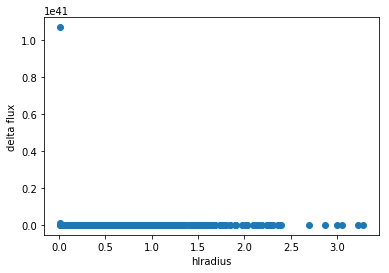

Text(0, 0.5, 'matrix flux')

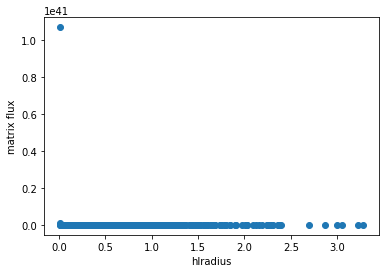

In [6]:
#x = plt.hist(_HLR, bins = 30, range=[0, 0.2]);
#print(x[0])
#print(x[1])
plt.figure()
plt.scatter(_HLR, deltafluxes);
plt.xlabel("hlradius")
plt.ylabel("delta flux")
plt.show()


plt.figure()
plt.scatter(_HLR, matrixfluxes);
plt.xlabel("hlradius")
plt.ylabel("matrix flux")

<Figure size 432x288 with 0 Axes>

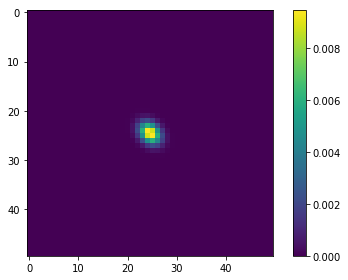

In [7]:
plt.figure()
f, ax = plt.subplots(1, 1)
im = ax.imshow(images[704].array)
f.colorbar(im, ax=ax)
plt.tight_layout()

In [8]:
print(_HLR[817], RBAND[817])
print(cheat)
print(_HLR[816], RBAND[816])
print(np.sum(_HLR)/len(_HLR))
#LMAG = fitsio.read(file, columns = 'LMAG', rows=span, ext=1)
#EPSILON = fitsio.read(file, columns='EPSILON', rows=span, ext=1)
#RBAND = LMAG[:,1]
#E1 = EPSILON[:,0]
#E2 = EPSILON[:,1]

0.029314217378540914 24.138329800462884


NameError: name 'cheat' is not defined